In [20]:
import pandas as pd
import json
import os
from PIL import Image
from transformers import CLIPModel, CLIPProcessor
import torch

# ==== Data Loading & Cleaning ====
# Load data
df = pd.read_csv('instagram_posts.csv')

# Parse ImageLabels column (pipe-separated)
def safe_parse_list(s):
    if pd.isnull(s) or s in ('None', ''):
        return []
    return [label.strip() for label in s.split('|')]

df['image_list'] = df['ImageLabels'].apply(safe_parse_list)

# Parse Hashtags column (pipe-separated)
def safe_parse_hashtags(s):
    if pd.isnull(s) or s in ('None', ''):
        return []
    return [tag.strip() for tag in s.split('|')]

df['caption'] = df['Caption'].fillna('').astype(str).str.strip()
df['hashtag'] = df['Hashtags'].apply(safe_parse_hashtags)

# Remove rows with Likes less than 4
df = df[df['Likes'] >= 4].copy()
df['hashtag(cont)'] = df['hashtag'].apply(lambda lst: ' '.join(lst))
# Combined column: caption + hashtags
df['combined'] = df.apply(lambda row: f"{row['caption']} {row['hashtag']}".strip(), axis=1)

# Keep only rows with at least one valid image label
df_clean = df[df['image_list'].apply(lambda lst: len(lst) > 0)].reset_index(drop=True)

# Now df_clean has three key columns:
# 'caption' (cleaned caption text)
# 'hashtag' (hashtags as space-separated string)
# 'combined' (caption + hashtag together)



C:\Users\huynh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


                                 InstagramLink    AccountUsername        Date  \
0     https://www.instagram.com/p/DLaI5yzuUwy/         humansofny  2025-06-27   
1     https://www.instagram.com/p/DN55iV0DeEc/         humansofny  2025-08-28   
2     https://www.instagram.com/p/DNydbZ03Lpm/         humansofny  2025-08-25   
3     https://www.instagram.com/p/DNqrwcnu90s/         humansofny  2025-08-22   
4     https://www.instagram.com/p/DNoEmoutjg0/         humansofny  2025-08-21   
...                                        ...                ...         ...   
2082  https://www.instagram.com/p/DGcyc7tonBk/  streetlevelphotos  2025-02-24   
2083  https://www.instagram.com/p/DGXrL8lIA1G/  streetlevelphotos  2025-02-22   
2084  https://www.instagram.com/p/DGVKzBNoluR/  streetlevelphotos  2025-02-21   
2101  https://www.instagram.com/p/Cih9FKxoBw4/   _pkm_photography  2022-09-15   
2106  https://www.instagram.com/p/DJ42m9WooV1/   _pkm_photography  2025-05-20   

                           

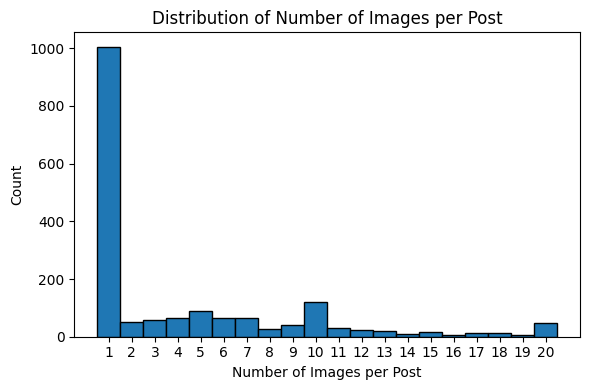

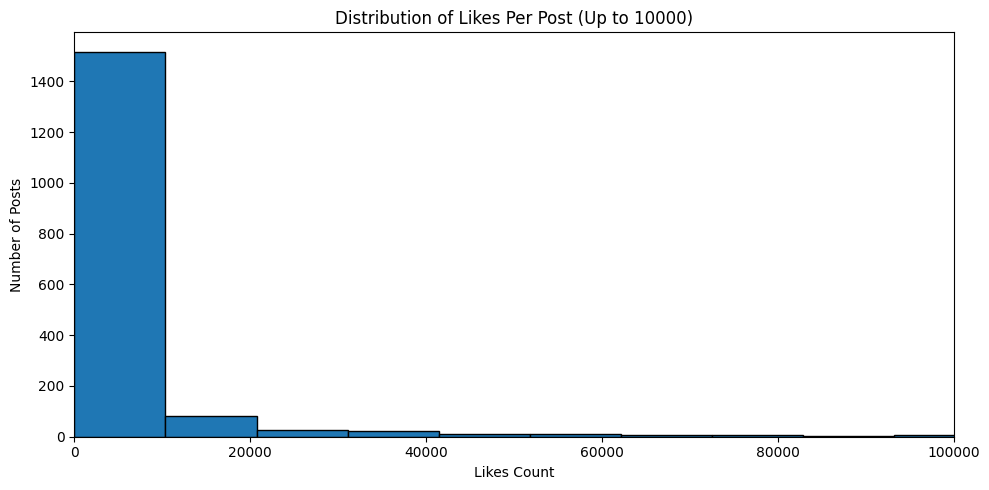

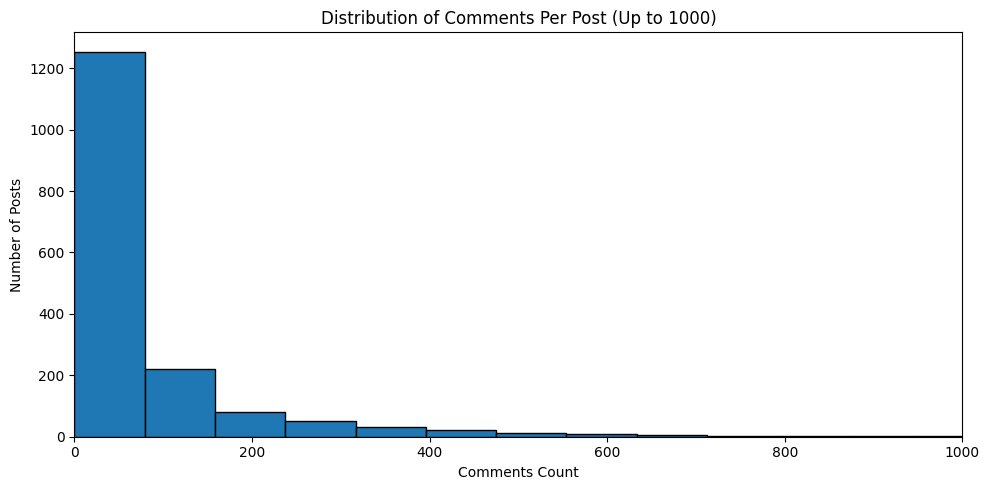

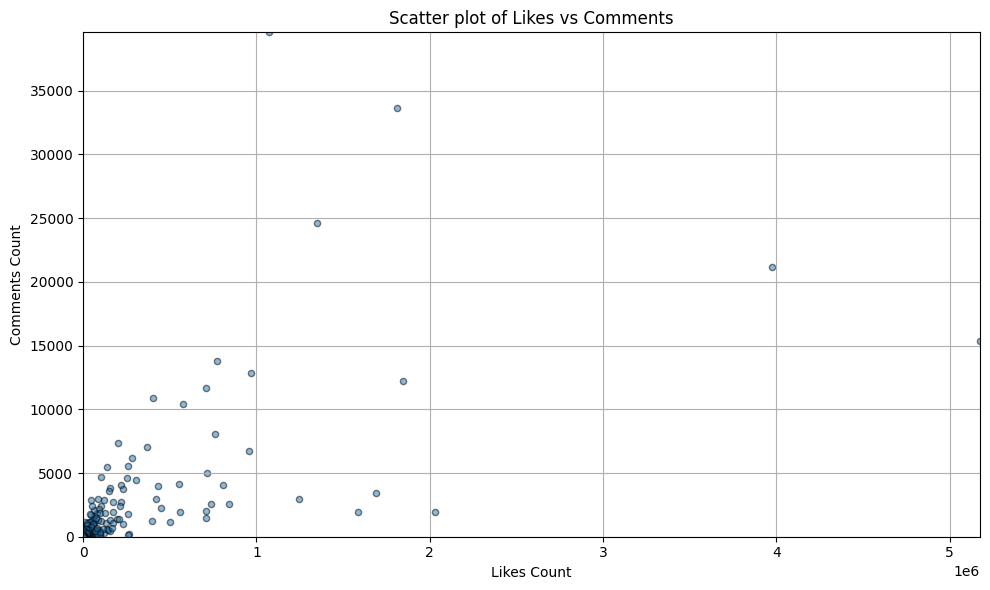

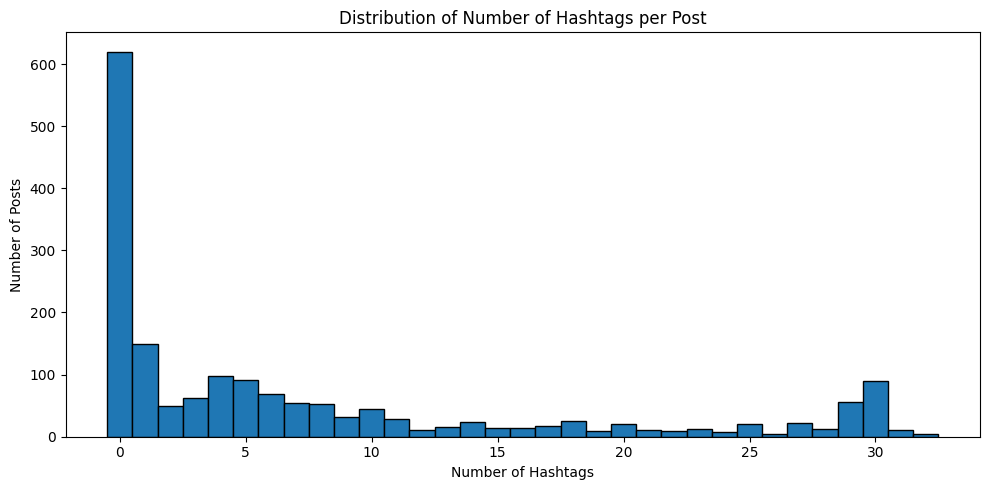

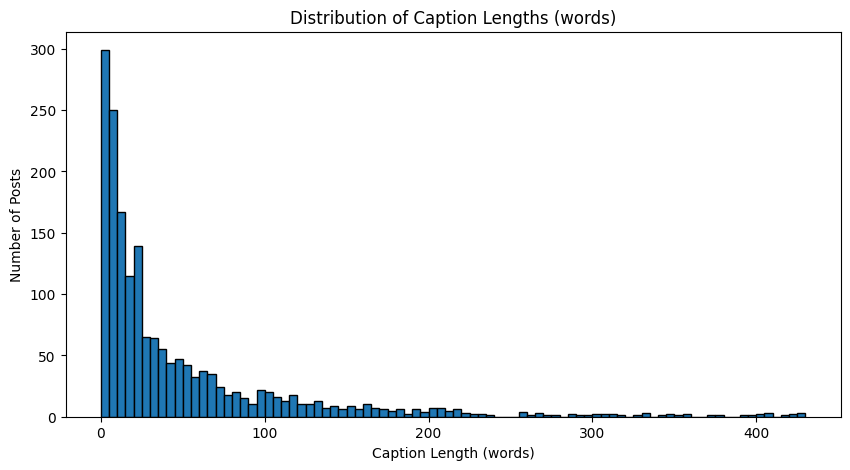

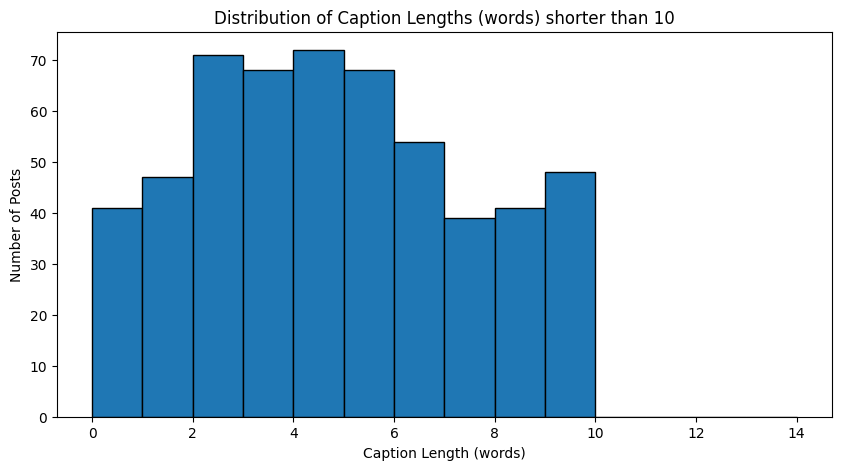

In [45]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Helper function to safely count elements in a column of lists, treating None as empty list
def safe_count_series(series):
    return series.apply(lambda x: len(x) if isinstance(x, list) else 0)  # [web:6][web:11]
print(df)
# 1. Histogram: Images per post
img_counts = safe_count_series(df['image_list'])
bins = np.arange(img_counts.min(), img_counts.max() + 2) - 0.5
plt.figure(figsize=(6, 4))
plt.hist(img_counts, bins=bins, edgecolor='black')
plt.xlabel('Number of Images per Post')
plt.ylabel('Count')
plt.title('Distribution of Number of Images per Post')
plt.xticks(np.arange(img_counts.min(), img_counts.max() + 1, 1))
plt.tight_layout()
plt.show()  # [web:1][web:10]

# Helper function for simple histograms
def plot_histogram(data, bins, xlabel, ylabel, title, figsize=(10, 5), xlim=None):
    plt.figure(figsize=figsize)
    plt.hist(data, bins=bins, edgecolor='black')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if xlim:
        plt.xlim(xlim)
    plt.tight_layout()
    plt.show()

# 2. Histogram: Likes per post (up to 10000)
likes = df['Likes'].fillna(0)
plot_histogram(
    data=likes,
    bins=500,
    xlabel='Likes Count',
    ylabel='Number of Posts',
    title='Distribution of Likes Per Post (Up to 10000)',
    xlim=(0, 100000)
)

# 3. Histogram: Comments per post (up to 1000)
comments = df['Comments'].fillna(0)
plot_histogram(
    data=comments,
    bins=500,
    xlabel='Comments Count',
    ylabel='Number of Posts',
    title='Distribution of Comments Per Post (Up to 1000)',
    xlim=(0, 1000)
)

# 4. Scatter plot: Likes vs. Comments
plt.figure(figsize=(10, 6))
plt.scatter(likes, comments, alpha=0.5, edgecolor='k', s=20)
plt.xlabel('Likes Count')
plt.ylabel('Comments Count')
plt.title('Scatter plot of Likes vs Comments')
plt.xlim(0, likes.max() + 100)
plt.ylim(0, comments.max() + 10)
plt.grid(True)
plt.tight_layout()
plt.show()  # [web:5][web:7]

# 5. Histogram: Hashtags per post
hashtags_counts = safe_count_series(df['hashtag'])
plot_histogram(
    data=hashtags_counts,
    bins=np.arange(0, hashtags_counts.max() + 2) - 0.5,
    xlabel='Number of Hashtags',
    ylabel='Number of Posts',
    title='Distribution of Number of Hashtags per Post',
    figsize=(10, 5)
)

# Calculate caption lengths in words
caption_lengths = df_clean['Caption'].fillna("").astype(str).apply(lambda x: len(x.split()))

# Prepare histogram bins with interval size 5 words
bins = np.arange(0, caption_lengths.max() + 5, 5)

# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(caption_lengths, bins=bins, edgecolor='black')
plt.xlabel('Caption Length (words)')
plt.ylabel('Number of Posts')
plt.title('Distribution of Caption Lengths (words)')
plt.show()

max_caption_length = 10  # Set your desired max length here

# Calculate caption lengths and filter for short captions only
caption_lengths = df_clean['caption'].fillna("").astype(str).apply(lambda x: len(x.split()))
filtered_lengths = caption_lengths[caption_lengths < max_caption_length]

# Prepare bins (e.g., 5 words interval)
bins = np.arange(0, max_caption_length + 5, 1)

# Plot histogram for filtered caption lengths
plt.figure(figsize=(10, 5))
plt.hist(filtered_lengths, bins=bins, edgecolor='black')
plt.xlabel('Caption Length (words)')
plt.ylabel('Number of Posts')
plt.title(f'Distribution of Caption Lengths (words) shorter than {max_caption_length}')
plt.show()


In [22]:
# ==== Initialize CLIP Model & Processor ====
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

# Construct local image folder path based on AccountUsername and Date
def get_image_folder(row):
    return os.path.join('photos', row['AccountUsername'], row['Date'])

# Load image from local disk, try common extensions
def load_local_image(img_folder, img_label):
    for ext in ['.jpg', '.jpeg', '.png','.webp']:
        img_path = os.path.join(img_folder, img_label + ".jpg"+ ext)
        if os.path.isfile(img_path):
            return Image.open(img_path).convert('RGB')
        # else:
        #     print("Problem loading img", img_path)
    return None

# Extract CLIP features from local image
def extract_clip_features_local(img_folder, img_label):
    try:
        img = load_local_image(img_folder, img_label)
        if img is None:
            print(f"Image not found: {img_label} in {img_folder}")
            return None
        inputs = clip_processor(images=img, return_tensors="pt")
        with torch.no_grad():
            img_features = clip_model.get_image_features(**inputs).cpu().numpy()[0]
        return img_features
    except Exception as e:
        print(f"Error processing image {img_label} in {img_folder}: {e}")
        return None
import numpy as np

# # Initialize a list to store features for all rows
# all_features = []

# # Loop through every row in the dataframe
# for idx, row in df_clean.iterrows():
#     img_folder = get_image_folder(row)
    
#     # Assume 'image_list' column contains a list of image labels per row
#     features_for_row = []
#     for img_label in row['image_list']:
#         img_features = extract_clip_features_local(img_folder, img_label)
#         if img_features is not None:
#             features_for_row.append(img_features)
#     # Aggregate features for row (e.g., average if multiple images per row)
#     if features_for_row:
#         avg_features = np.mean(features_for_row, axis=0)
#     else:
#         avg_features = None
    
#     all_features.append(avg_features)

# # Add the aggregated features as a new column in df_clean
# df['clip_features'] = all_features
# df.to_csv("insta_posts_features.csv")

In [16]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
import ast

df_clean = pd.read_csv("insta_posts_features.csv")
# ================== Text Tokenization ==================
def custom_standardization(input_data):
    # Convert to lowercase
    lowercase = tf.strings.lower(input_data)
    # Remove URLs
    no_urls = tf.strings.regex_replace(lowercase, r'https?://\S+|www\.\S+', '')
    # Remove emojis and non-alphanumeric characters except spaces
    no_emojis = tf.strings.regex_replace(no_urls, r'[^\w\s]', '')
    # Optional: remove extra spaces
    cleaned = tf.strings.regex_replace(no_emojis, r'\s+', ' ')
    return cleaned

max_len = 50
vectorizer = TextVectorization(
    max_tokens=15000,
    output_sequence_length=max_len,
    output_mode='int',
    standardize=custom_standardization
)

texts = df_clean['caption'].fillna("").astype(str).tolist() + \
        df_clean['hashtag(cont)'].fillna("").astype(str).tolist() + \
        df_clean['combined'].fillna("").astype(str).tolist()

vectorizer.adapt(texts)
vocab = vectorizer.get_vocabulary()
vocab_size = len(vocab)  
def tokenize_text(text):
    # Ensure text is string
    if not isinstance(text, str):
        text = str(text)
        # print(text)

    text_tensor = tf.convert_to_tensor([text], dtype=tf.string)  # explicitly string dtype
    tokens = vectorizer(text_tensor)
    return tokens[0].numpy()  # sequence of ints


# ================== tf.data.Dataset Pipeline ==================

def parse_features(feature_str):
    # Remove brackets first
    feature_str = feature_str.strip("[]")
    # Replace multiple spaces with a single space
    feature_str = " ".join(feature_str.split())
    # Replace spaces with commas
    feature_str = feature_str.replace(" ", ",")
    # Convert to numpy array
    arr = np.fromstring(feature_str, sep=",", dtype=np.float32)
    return arr

# Then in your generator:
df_clean = df_clean[df_clean['caption'].str.strip().astype(bool)]

def gen_examples(text_col):
    for _, row in df_clean.iterrows():
        text = row[text_col]
        feats = parse_features(row["clip_features"])
        if feats is None or not text:
            continue
        tokens = tokenize_text(text)
        tokens = np.clip(tokens, 0, vocab_size - 1).astype(np.int32)
        assert tokens.min() >= 0 and tokens.max() < vocab_size, "Token indices out of range!"
        for i in range(1, len(tokens)):
            in_seq = tokens[:i]
            out_word = np.int32(tokens[i])
            in_seq_padded = np.zeros(max_len, dtype=np.int32)
            in_seq_padded[-len(in_seq):] = in_seq
            assert in_seq_padded.max() < vocab_size, "Padded input sequence has invalid token index!"
            feats = feats.astype(np.float32)
            yield (feats, in_seq_padded), out_word


def make_tf_dataset(text_col, batch_size=16):
    output_types = ((tf.float32, tf.int32), tf.int32)  # tuple, not list
    output_shapes = ((512,), (max_len,)), ()            # tuple of tuples

    dataset = tf.data.Dataset.from_generator(
        lambda: gen_examples(text_col),
        output_types=output_types,
        output_shapes=output_shapes
    )
    dataset = dataset.batch(batch_size)
    return dataset
print("Actual tokenizer vocab size:", len(vectorizer.get_vocabulary()))
for batch_inputs, batch_targets in make_tf_dataset('caption').take(5):
    print("Max token in input sequence:", tf.reduce_max(batch_inputs[1]).numpy())
    print("Max target token:", tf.reduce_max(batch_targets).numpy())


Actual tokenizer vocab size: 13842
Max token in input sequence: 2233
Max target token: 2233
Max token in input sequence: 9719
Max target token: 10586
Max token in input sequence: 11855
Max target token: 11855
Max token in input sequence: 11855
Max target token: 8795
Max token in input sequence: 8795
Max target token: 2817


Epoch 1/10
5397/5397 ━━━━━━━━━━━━━━━━━━━━ 426s 78ms/step - accuracy: 0.5229 - loss: 4.2340
Epoch 2/10
   2/5397 ━━━━━━━━━━━━━━━━━━━━ 7:00 78ms/step - accuracy: 0.0000e+00 - loss: 6.7534  

C:\Users\huynh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


5397/5397 ━━━━━━━━━━━━━━━━━━━━ 425s 79ms/step - accuracy: 0.5304 - loss: 3.3737
Epoch 3/10
5397/5397 ━━━━━━━━━━━━━━━━━━━━ 424s 79ms/step - accuracy: 0.5386 - loss: 3.0985
Epoch 4/10
5397/5397 ━━━━━━━━━━━━━━━━━━━━ 443s 82ms/step - accuracy: 0.5474 - loss: 2.8603
Epoch 5/10
5397/5397 ━━━━━━━━━━━━━━━━━━━━ 412s 76ms/step - accuracy: 0.5592 - loss: 2.6537
Epoch 6/10
5397/5397 ━━━━━━━━━━━━━━━━━━━━ 380s 70ms/step - accuracy: 0.5730 - loss: 2.4909
Epoch 7/10
5397/5397 ━━━━━━━━━━━━━━━━━━━━ 404s 75ms/step - accuracy: 0.5865 - loss: 2.3339
Epoch 8/10
5397/5397 ━━━━━━━━━━━━━━━━━━━━ 399s 74ms/step - accuracy: 0.5987 - loss: 2.2027
Epoch 9/10
5397/5397 ━━━━━━━━━━━━━━━━━━━━ 271s 50ms/step - accuracy: 0.6124 - loss: 2.0781
Epoch 10/10
5397/5397 ━━━━━━━━━━━━━━━━━━━━ 291s 54ms/step - accuracy: 0.6224 - loss: 1.9661
Epoch 1/10
5397/5397 ━━━━━━━━━━━━━━━━━━━━ 368s 68ms/step - accuracy: 0.8585 - loss: 1.4972
Epoch 2/10
5397/5397 ━━━━━━━━━━━━━━━━━━━━ 380s 70ms/step - accuracy: 0.8593 - loss: 0.9785
Epoch 3/1

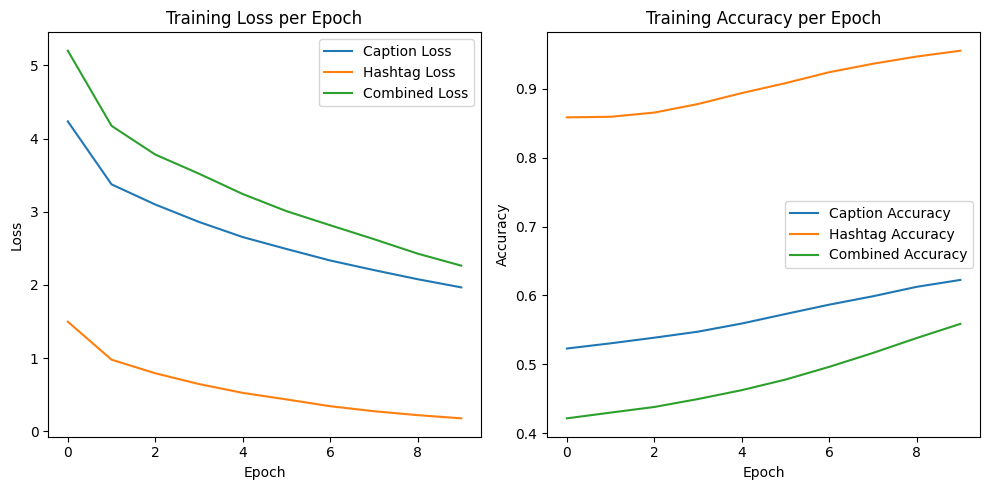

NameError: name 'img_url' is not defined

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Concatenate, Dense
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score

# ================== Model ==================
def build_model():
    img_input = Input(shape=(512,))
    txt_input = Input(shape=(max_len,), dtype=tf.int32)
    embed_txt = Embedding(input_dim=vocab_size, output_dim=256, mask_zero=True)(txt_input)
    txt_out = LSTM(256)(embed_txt)
    merged = Concatenate()([img_input, txt_out])
    dense1 = Dense(256, activation='relu')(merged)
    output = Dense(vocab_size, activation='softmax')(dense1)
    model = tf.keras.models.Model([img_input, txt_input], output)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model_caption = build_model()
model_hashtag = build_model()
model_combined = build_model()

# ================== Training ==================
history_caption = model_caption.fit(make_tf_dataset('caption'), epochs=10)
history_hashtag = model_hashtag.fit(make_tf_dataset('hashtag(cont)'), epochs=10)
history_combined = model_combined.fit(make_tf_dataset('combined'), epochs=10)

# ================== Visualization ==================
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history_caption.history['loss'], label="Caption Loss")
plt.plot(history_hashtag.history['loss'], label="Hashtag Loss")
plt.plot(history_combined.history['loss'], label="Combined Loss")
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_caption.history['accuracy'], label="Caption Accuracy")
plt.plot(history_hashtag.history['accuracy'], label="Hashtag Accuracy")
plt.plot(history_combined.history['accuracy'], label="Combined Accuracy")
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# ================== Caption Generation ==================
def generate_caption(img_folder,img_label, model, tokenizer, max_len=30):
    feats = extract_clip_features_local(img_folder,img_label)
    if feats is None:
        return ""
    
    # Start input tokens as empty or with start token index if applicable
    input_tokens = []
    
    for _ in range(max_len):
        # Pad the input tokens sequence to max_len
        padded_tokens = np.zeros(max_len, dtype=np.int32)
        padded_tokens[-len(input_tokens):] = input_tokens  # right pad
        
        preds = model.predict([feats.reshape(1, 512).astype(np.float32), padded_tokens.reshape(1, max_len)])
        yhat = np.argmax(preds[0])
        
        # Get the predicted word from tokenizer vocabulary
        word = vectorizer.get_vocabulary()[yhat]
        
        if word in ['', '[UNK]', '[SEP]']:  # Stop if end token or unknown
            break
        
        input_tokens.append(yhat)
    
    # Decode token IDs to words
    caption = ' '.join([vectorizer.get_vocabulary()[tok] for tok in input_tokens])
    return caption.strip()


# ================== Evaluation ==================
def evaluate_caption_scores(references, candidates):
    bleu_scores = [sentence_bleu([ref.split()], cand.split()) for ref, cand in zip(references, candidates)]
    meteor_scores = [meteor_score([ref], cand) for ref, cand in zip(references, candidates)]
    # For CIDEr, use pycocoevalcap or coco-caption if you wish
    return bleu_scores, meteor_scores

img_folder="D:/Resumes and Portfolios/Photography/Insta/09152025/"
img_label="09152025-1.jpg"
ref_caption = df_clean.iloc[0]['caption']
gen_caption_caption = generate_caption(img_folder,img_label, model_caption, tokenize_text, max_len=30)
bleu, meteor = evaluate_caption_scores([ref_caption], [gen_caption_caption])
print("Generated Caption:", gen_caption_caption)
print("BLEU:", bleu)
print("METEOR:", meteor)

In [ ]:
# ================== Caption Generation ==================
def generate_caption(img_folder,img_label, model, tokenizer, max_len=30):
    feats = extract_clip_features_local(img_folder,img_label)
    if feats is None:
        return ""
    
    # Start input tokens as empty or with start token index if applicable
    input_tokens = [0]
    
    for _ in range(max_len):
        # Pad the input tokens sequence to max_len
        padded_tokens = np.zeros(max_len, dtype=np.int32)
        if len(input_tokens) > 0:
            padded_tokens[-len(input_tokens):] = input_tokens  # right pad only if tokens exist        
        preds = model.predict([feats.reshape(1, 512).astype(np.float32), padded_tokens.reshape(1, max_len)],verbose=0)
        yhat = np.argmax(preds[0])
        
        # Get the predicted word from tokenizer vocabulary
        word = vectorizer.get_vocabulary()[yhat]
        
        # if word in ['', '[UNK]', '[SEP]']:  # Stop if end token or unknown
        #     break
        
        input_tokens.append(yhat)
    
    # Decode token IDs to words
    caption = ' '.join([vectorizer.get_vocabulary()[tok] for tok in input_tokens])
    return caption.strip()


# ================== Evaluation ==================
def evaluate_caption_scores(references, candidates):
    bleu_scores = [sentence_bleu([ref.split()], cand.split()) for ref, cand in zip(references, candidates)]
    meteor_scores = [meteor_score([ref.split()], cand.split()) for ref, cand in zip(references, candidates)]
    return bleu_scores, meteor_scores

for df_clean
ref_caption = df_clean.iloc[0]['caption']

gen_caption_caption = generate_caption(img_folder, img_label, model_caption, tokenize_text, max_len=50)
print("Generated Caption:", gen_caption_caption)

gen_caption_caption = generate_caption(img_folder, img_label, model_hashtag, tokenize_text, max_len=50)
print("Generated Caption:", gen_caption_caption)

gen_caption_caption = generate_caption(img_folder, img_label, model_combined, tokenize_text, max_len=50)
print("Generated Caption:", gen_caption_caption)

# bleu, meteor = evaluate_caption_scores([ref_caption], [gen_caption_caption])

# print("BLEU:", bleu)
# print("METEOR:", meteor)

Generated Caption: 
Generated Caption: everybodystreet
Generated Caption: of taken by thestreetphotographyhub thestreetphotographyhub contrast thestreetphotographyhub thestreetphotographyhub streetphotographybrazil bcncollective thestreetphotographyhub myspc thestreetphotographyhub thestreetphotographyhub thestreetphotographyhub thestreetphotographyhub thestreetphotographyhub thestreetphotographyhub thestreetphotographyhub thestreetphotographyhub thestreetphotographyhub thestreetphotographyhub thestreetphotographyhub thestreetphotographyhub thestreetphotographyhub thestreetphotographyhub thestreetphotographyhub thestreetphotographyhub thestreetphotographyhub thestreetphotographyhub thestreetphotographyhub thestreetphotographyhub thestreetphotographyhub thestreetphotographyhub thestreetphotographyhub thestreetphotographyhub thestreetphotographyhub thestreetphotographyhub thestreetphotographyhub thestreetphotographyhub thestreetphotographyhub thestreetphotographyhub thestreetphotographyh